# Tutorial 1: Basics

<img src="../../imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:100%;"/>

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML)


In this tutorial you will learn how to:
* run LightAutoML training on tabular data
* obtain feature importances and reports
* configure resource usage in LightAutoML

## 0. Prerequisites

### 0.0. install LightAutoML

In [1]:
#!pip install -U lightautoml

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS and HTTP requests etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Standard python libraries
import os
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco
from lightautoml.addons.interpretation import SSWARM

### 0.2. Constants

Here we setup some parameters to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [4]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'TARGET'

In [5]:
DATASET_DIR = '../data/'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)
DATASET_URL = 'https://raw.githubusercontent.com/AILab-MLTools/LightAutoML/master/examples/data/sampled_app_train.csv'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [6]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [7]:
if not os.path.exists(DATASET_FULLNAME):
    os.makedirs(DATASET_DIR, exist_ok=True)

    dataset = requests.get(DATASET_URL).text
    with open(DATASET_FULLNAME, 'w') as output:
        output.write(dataset)

In [8]:
data = pd.read_csv(DATASET_DIR + DATASET_NAME)
data.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      313802       0         Cash loans           M            N   
1      319656       0         Cash loans           F            N   
2      207678       0    Revolving loans           F            Y   
3      381593       0         Cash loans           F            N   
4      258153       0         Cash loans           F            Y   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          270000.0    327024.0      15372.0   
1               N             0          108000.0    675000.0      19737.0   
2               Y             2          112500.0    270000.0      13500.0   
3               N             1           67500.0    142200.0       9630.0   
4               Y             0          337500.0   1483231.5      46570.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        2.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         1.0  
3                        0.0                         4.0  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [9]:
data.shape

(10000, 122)

### 0.5. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [10]:
train_data, test_data = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    stratify=data[TARGET_NAME], 
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Data is splitted. Parts sizes: train_data = (8000, 122), test_data = (2000, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
6444      112261       0         Cash loans           F            N   
3586      115058       0         Cash loans           F            N   
9349      326623       0         Cash loans           F            N   
7734      191976       0         Cash loans           M            Y   
2174      281519       0    Revolving loans           F            N   

     FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
6444               N             1           90000.0    640080.0      31261.5   
3586               Y             0          180000.0    239850.0      23850.0   
9349               Y             0          112500.0    337500.0      31086.0   
7734               Y             1           67500.0    135000.0       9018.0   
2174               Y             0           67500.0    202500.0      10125.0   

      ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
6444  ...                 0                0                0   
3586  ...                 0                0                0   
9349  ...                 0                0                0   
7734  ...                 0                0                0   
2174  ...                 0                0                0   

     FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
6444                0                        0.0                       0.0   
3586                0                        0.0                       0.0   
9349                0                        0.0                       0.0   
7734                0                        NaN                       NaN   
2174                0                        0.0                       0.0   

      AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
6444                         0.0                        0.0   
3586                         0.0                        0.0   
9349                         0.0                        0.0   
7734                         NaN                        NaN   
2174                         0.0                        0.0   

      AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
6444                        1.0                         0.0  
3586                        0.0                         3.0  
9349                        0.0                         2.0  
7734                        NaN                         NaN  
2174                        0.0                         2.0  

[5 rows x 122 columns]

Note: missing values (NaN and other) in the data should be left as is, unless the reason for their presence or their specific meaning are known. Otherwise, AutoML model will perceive the filled NaNs as a true pattern between the data and the target variable, without knowledge and assumptions about missing values, which can negatively affect the model quality. LighAutoML can deal with missing values and outliers automatically.

## 1. Task definition

### 1.1. Task type

First we need to create ```Task``` object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation).

The following task types are available:

- ```'binary'``` - for binary classification.

- ```'reg’``` - for regression.

- ```‘multiclass’``` - for multiclass classification.

- ```'multi:reg``` - for multiple regression.

- ```'multilabel'``` - for multi-label classification.

In this example we will consider a binary classification:

In [11]:
task = Task('binary')

Note: only logloss loss is available for binary task and it is the default loss. Default metric for binary classification is ROC-AUC. See more info about available and default losses and metrics [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task). 

**Depending on the task, you can and shold choose exactly those metrics and losses that you want and need to optimize.**

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. LightAutoML can automatically define types and roles of data columns, but it is possible to specify it directly through the dictionary parameter ```roles``` when training AutoML model (see next section "AutoML training"). Specific roles can be specified using a string with the name (any role can be set like this).  So the key in dictionary must be the name of the role, the value must be a list of the names of the corresponding columns in dataset. The **only role you must setup is** ```'target'``` **role** (that is column with target variable obviously), everything else (```'drop', 'numeric', 'categorical', 'group', 'weights'``` etc) is up to user:

In [12]:
roles = {
    'target': TARGET_NAME,
    'drop': ['SK_ID_CURR']
}

You can also optionally specify the following roles:

- ```'numeric'``` - numerical feature

- ```'category'``` - categorical feature

- ```'text'``` - text data

- ```'datetime'``` - features with date and time 

- ```'date'``` - features with date only

- ```'group'``` - features by which the data can be divided into groups and which can be taken into account for group k-fold validation (so the same group is not represented in both testing and training sets)

- ```'drop'``` - features to drop, they will not be used in model building

- ```'weights'``` - object weights for the loss and metric

- ```'path'``` - image file paths (for CV tasks)

- ```'treatment'``` - object group in uplift modelling tasks: treatment or control

Note: role name can be written in any case. Also it is possible to pass individual objects of role classes with specific arguments instead of strings with role names for specific tasks and more optimal pipeline construction ([more details](https://github.com/sb-ai-lab/LightAutoML/blob/master/lightautoml/dataset/roles.py)).

For example, to set the date role, you can use the ```DatetimeRole``` class. 

In [13]:
#from lightautoml.dataset.roles import DatetimeRole

Different seasonality can be extracted from the data through the ```seasonality``` parameter: years (```'y'```), months (```'m'```), days (```'d'```), weekdays (```'wd'```), hours (```'hour'```), minutes (```'min'```), seconds (```'sec'```), milliseconds (```'ms'```), nanoseconds (```'ns'```). This features will be considered as categorical. Another important parameter is ```base_date```. It allows to specify the base date and convert the feature to the distances to this date (set to ```False``` by default). Also for all roles classes there is a ```force_input``` parameter, and if it is ```True```, then the corresponding features will pass all further feature selections and won't be excluded (equals ```False``` by default). Also it is always possible to specify data type for all roles using ```dtype``` argument.

Here is an example of such a role assignment through a class object for date feature (but there is no such feature in the considered dataset):

In [14]:
# roles = {
#     DatetimeRole(base_date=False, seasonality=('d', 'wd', 'hour')): 'date_time'
# }

Any role can be set through a class object. Information about specific parameters of specific roles and other datailed information can be found [here](https://github.com/sb-ai-lab/LightAutoML/blob/master/lightautoml/dataset/roles.py).

### 1.3. LightAutoML model creation - TabularAutoML preset

Next we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure in just several lines. 

In general, the whole AutoML model consists of multiple levels, which can contain several pipelines with their own set of data processing methods and ML models. The outputs of one level are the inputs of the next, and on the last level predictions of previous level models are combined with blending procedure. All this can be combined into a model using the ```AutoML``` class and its various descendants (like ```TabularAutoML```).

Let's look at how the LightAutoML model is arranged and what it consists in general.

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/master/imgs/tutorial_1_laml_big.png)

#### 1.3.1 Reader object

First the task and data go into ```Reader``` object. It analyzes the data and extracts various valuable information from them. Also it can detect and remove useless features, conduct feature selection, determine types and roles etc. Let's look at this steps in more detail.

**Role and types guessing**

Roles can be specified as a string or a specific class object, or defined automatically. For ```TabularAutoML``` preset ```'numeric'```, ```'datetime'``` and ```'category'``` roles can be automatically defined. There are two ways of role defining. **First** is very simple: check if the value can be converted to a date (```'datetime'```), otherwise check if it can be converted to a number (```'numeric'```), otherwise declare it a category (```'categorical'```). But this method may not work well on large data or when encoding categories with integers. The **second** method is based on statistics: the distributions of numerical features are considered, and how similar they are to the distributions of real or categorical value. Also different ways of feature encoding (as a number or as a category) are compared and based on normalized Gini index it is decided which encoding is better. For this case a set of specific rules is created, and if at least one of them is fullfilled, then the feature will be assigned to numerical, otherwise to categorical. This check can be enabled or disabled using the ```advanced_roles``` parameter. 

If roles are explicitly specified, automatic definition won't be applied to the specified dataset columns. In the case of specifying a role as an object of a certain class, through its arguments, it is possible to set the processing parameters in more detail.
 
**Feature selection**

In general, the AutoML pipeline uses pre-selection, generation and post-selection of features. ```TabularAutoML``` has no post-selection stage. There are three feature selection methods: its absence, using features importances and more strict selection (forward selection). The GBM model is used to evaluate features importances. Importances can be calculated in 2 ways: based on splits (how many times a split was made for each feature in the entire ensemble) or using permutation feature importances (mixing feature values during validation and assessing quality change in this case). Second method is harder but it requires holdout data. Then features with importance above a certain threshold are selected. Faster and more strict feature selection method is forward selection. Features are sorted in descending order of importance, then in blocks (size of 1 by default) a model is built based on selected features, and its quality is measured. Then the next block of features is added, and they are saved if the quality has improved with them, and so on.  

Also LightAutoML can merge some columns if it is adequate and leads to an improvement in the model quality (for example, an intersection between categorical variables). Different columns join options are considered, the best one is chosen by the normalized Gini index. 

#### 1.3.2 Machine learning pipelines architecture and training

As a result, after analyzing and processing the data, the ```Reader``` object forms and returns a ```LAMA Dataset```. It contains the original data and markup with metainformation. In this dataset it is possible to see the roles defined by the ```Reader``` object, selected features etc. Then ML pipelines are trained on this data. 

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/master/imgs/tutorial_1_ml_pipeline.png)

Each such pipeline is one or more machine learning algorithms that share one post-processing block and one validation scheme. Several such pipelines can be trained in parallel on one dataset, and they form a level. Number of levels can be unlimited as possible. List of all levels of AutoML pipeline is available via ```.levels``` attribute of ```AutoML``` instance. Level predictions can be inputs to other models or ML pipelines (i. e. stacking scheme). As inputs for subsequent levels, it is possible to use the original data by setting ```skip_conn``` argument in ```True``` when initializing preset instance. At the last level, if there are several pipelines, blending is used to build a prediction. 

Different types of features are processed depending on the models. Numerical features are processed for linear model preprocessing: standardization, replacing missing values with median, discretization, log odds (if feature is probability - output of previous level). Categories are processed using label encoding (by default), one hot encoding, ordinal encoding, frequency encoding, out of fold target encoding. 

The following algorithms are available in the LightAutoML: linear regression with L2 regularization, LightGBM, CatBoost, random forest. 

By default KFold cross-validation is used during training at all levels (for hyperparameter optimization and building out-of-fold prediction during training), and for each algorithm a separate model is built for each validation fold, and their predictions are averaged. So the predictions at each level and the resulting prediction during training are out-of-fold predictions. But it is also possible to just pass a holdout data for validation or use custom cross-validation schemes, setting ```cv_iter``` iterator returning the indices of the objects for validation. LightAutoML has ready-made iterators, for example, ```TimeSeriesIterator``` for time series split. To further reduce the effect of overfitting, it is possible to use nested cross-validation (```nested_cv``` parameter), but it is not used by default. 

Prediction on new data is the averaging of models over all folds from validation and blending. 

Hyperparameter tuning of machine learning algorithms can be performed during training (early stopping by the number of trees in gradient boosting or the number of training epochs of neural networks etc), based on expert rules (according to data characteristics and empirical recommendations, so-called expert parameters), by the sequential model-based optimization (SMBO, bayesian optimization: Optuna with TPESampler) or by grid search. LightGBM and CatBoost can be used with parameter tuning or with expert parameters, with no tuning. For linear regression parameters are always tuned using warm start model training technique. 

At the last level blending is used to build a prediction. There are three available blending methods: choosing the best model based on a given metric (other models are just discarded), simple averaging of all models, or weighted averaging (weights are selected using coordinate descent algorithm with optimization of a given metric). ```TabularAutoML ``` uses the latter strategy by default. It is worth noting that, unlike stacking, blending can exclude models from composition. 

#### 1.3.3 Timing

When creating AutoML object, a certain time limit is set, and it schedules a list of tasks that it can complete during this time, and it will initially allocate approximately equal time for each task. In the process of solving objectives, it understands how to adjust the time allocated to different subtasks. If AutoML finished working earlier than set timeout, it means that it completed the entire list of tasks. If AutoML worked to the limit and turned off, then most likely it sacrificed something, for example, reduced the number of algorithms for training, realized that it would not have time to train the next one, or it might not calculate the full cross-validation cycle for one of the models (then on folds, where the model has not trained, the predictiuons will be NaN, and the model related to this fold will not participate in the final averaging). The resulting quality is evaluated at the blending stage, and if necessary and possible, the composition will be corrected. 

If you do not set the time for AutoML during initialization, then by default it will be equal to a very large number, that is, sooner or later AutoML will complete all tasks. 

#### 1.3.4 LightAutoML model creation

So the entire AutoML pipeline can be composed from various parts by user (see [custom pipeline tutorial](https://github.com/sb-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_6_custom_pipeline.ipynb)), but it is possible to use presets - in a certain sense, fixed strategies for dynamic pipeline building. 

Here is a default AutoML pipeline for binary classification and regression tasks (```TabularAutoML``` preset):

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/ac3c1b38873437eb74354fb44e68a449a0200aa6/imgs/tutorial_blackbox_pipeline.png)

Another example:

![](https://raw.githubusercontent.com/sb-ai-lab/LightAutoML/ac3c1b38873437eb74354fb44e68a449a0200aa6/imgs/tutorial_1_pipeline.png)

Let's discuss some of the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for ```Reader``` object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.
- `general_params` - general parameters dictionary, in which it is possible to specify a list of algorithms used (```'use_algos'```), nested CV using (```'nested_cv'```) etc.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sb-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we will use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one. 

In [15]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

## 2. AutoML training

To run autoML training use ```fit_predict``` method. 

Main arguments:

- `train_data` - dataset to train.
- `roles` - column roles dict.
- `verbose` - controls the verbosity: the higher, the more messages:
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [16]:
%%time 
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)

[08:51:44] Stdout logging level is INFO.
[08:51:44] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[08:51:44] Task: binary

[08:51:44] Start automl preset with listed constraints:
[08:51:44] - time: 300.00 seconds
[08:51:44] - CPU: 4 cores
[08:51:44] - memory: 16 GB

[08:51:44] Train data shape: (8000, 122)

[08:51:49] Layer 1 train process start. Time left 295.21 secs
[08:51:50] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[08:51:53] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7351798453933611
[08:51:53] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[08:51:53] Time left 291.10 secs

[08:51:55] Selector_LightGBM fitting and predicting completed
[08:51:56] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[08:52:07] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7331401653896874
[08:52:07] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[08:52:07] Start hyperparameters optimization for Lvl_

After training we can see logs with all the progress, final scores, weights assigned to the models in the final prediction etc.

Note that in this `fit_predict` you receive the model with only 3 out of 5 LightGBM models (you can see that from the log line in the end `0.25685 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM)`) - to fix it you can set the bigger timeout to make LightAutoML train all the models.

## 3. Prediction on holdout and model evaluation

Now we can use trained AutoML model to build predictions on holdout and evaluate model quality. Note that in case of classification tasks LightAutoML model returns probabilities as predictions.

In [17]:
%%time

test_predictions = automl.predict(test_data)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

Prediction for test_data:
array([[0.0620144 ],
       [0.0624553 ],
       [0.03260634],
       ...,
       [0.05459778],
       [0.03973836],
       [0.19107677]], dtype=float32)
Shape = (2000, 1)
CPU times: user 1.61 s, sys: 120 ms, total: 1.73 s
Wall time: 667 ms


In [18]:
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, out_of_fold_predictions.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

OOF score: 0.7500212068042909
HOLDOUT score: 0.7278328804347826


## 4. Model analysis

### 4.1. Reports

You can obtain the description of the resulting pipeline:

In [19]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.29331 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.09953 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.18318 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.42397 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


Also for this purposes LightAutoML have ```ReportDeco```, use it to build detailed reports:

In [20]:
RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task, 
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [21]:
%%time
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)

[08:55:07] Stdout logging level is INFO.
[08:55:07] Task: binary

[08:55:07] Start automl preset with listed constraints:
[08:55:07] - time: 300.00 seconds
[08:55:07] - CPU: 4 cores
[08:55:07] - memory: 16 GB

[08:55:07] Train data shape: (8000, 122)

[08:55:09] Layer 1 train process start. Time left 298.60 secs
[08:55:10] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[08:55:13] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7351798453933611
[08:55:13] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[08:55:13] Time left 294.63 secs

[08:55:15] Selector_LightGBM fitting and predicting completed
[08:55:16] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[08:55:27] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7331401653896874
[08:55:27] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[08:55:27] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 21.09 secs
[08:55:49] Hyperparameters optimization for Lvl_0_

The report will be available in the folder with specified name (```output_path``` argument in ```ReportDeco``` initialization).

In [22]:
!ls tabularAutoML_model_report

feature_importance.png		       test_roc_curve_1.png
lama_interactive_report.html	       valid_distribution_of_logits.png
test_distribution_of_logits_1.png      valid_pie_f1_metric.png
test_pie_f1_metric_1.png	       valid_pr_curve.png
test_pr_curve_1.png		       valid_preds_distribution_by_bins.png
test_preds_distribution_by_bins_1.png  valid_roc_curve.png


In [23]:
%%time

test_predictions = automl_rd.predict(test_data)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

Prediction for test_data:
array([[0.0620144 ],
       [0.0624553 ],
       [0.03260634],
       ...,
       [0.05459778],
       [0.03973836],
       [0.19107677]], dtype=float32)
Shape = (2000, 1)
CPU times: user 13.2 s, sys: 9.95 s, total: 23.1 s
Wall time: 3.4 s


In [24]:
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, out_of_fold_predictions.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

OOF score: 0.7500212068042909
HOLDOUT score: 0.7278328804347826


### 4.2 Feature importances calculation 


For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). There is no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In the cell below we will use `automl_rd.model` instead `automl_rd` because we want to take the importances from the model, not from the report. But **be carefull** - everything, which is calculated using `automl_rd.model` will not go to the report.

CPU times: user 405 ms, sys: 125 ms, total: 530 ms
Wall time: 294 ms


<Axes: xlabel='Feature'>

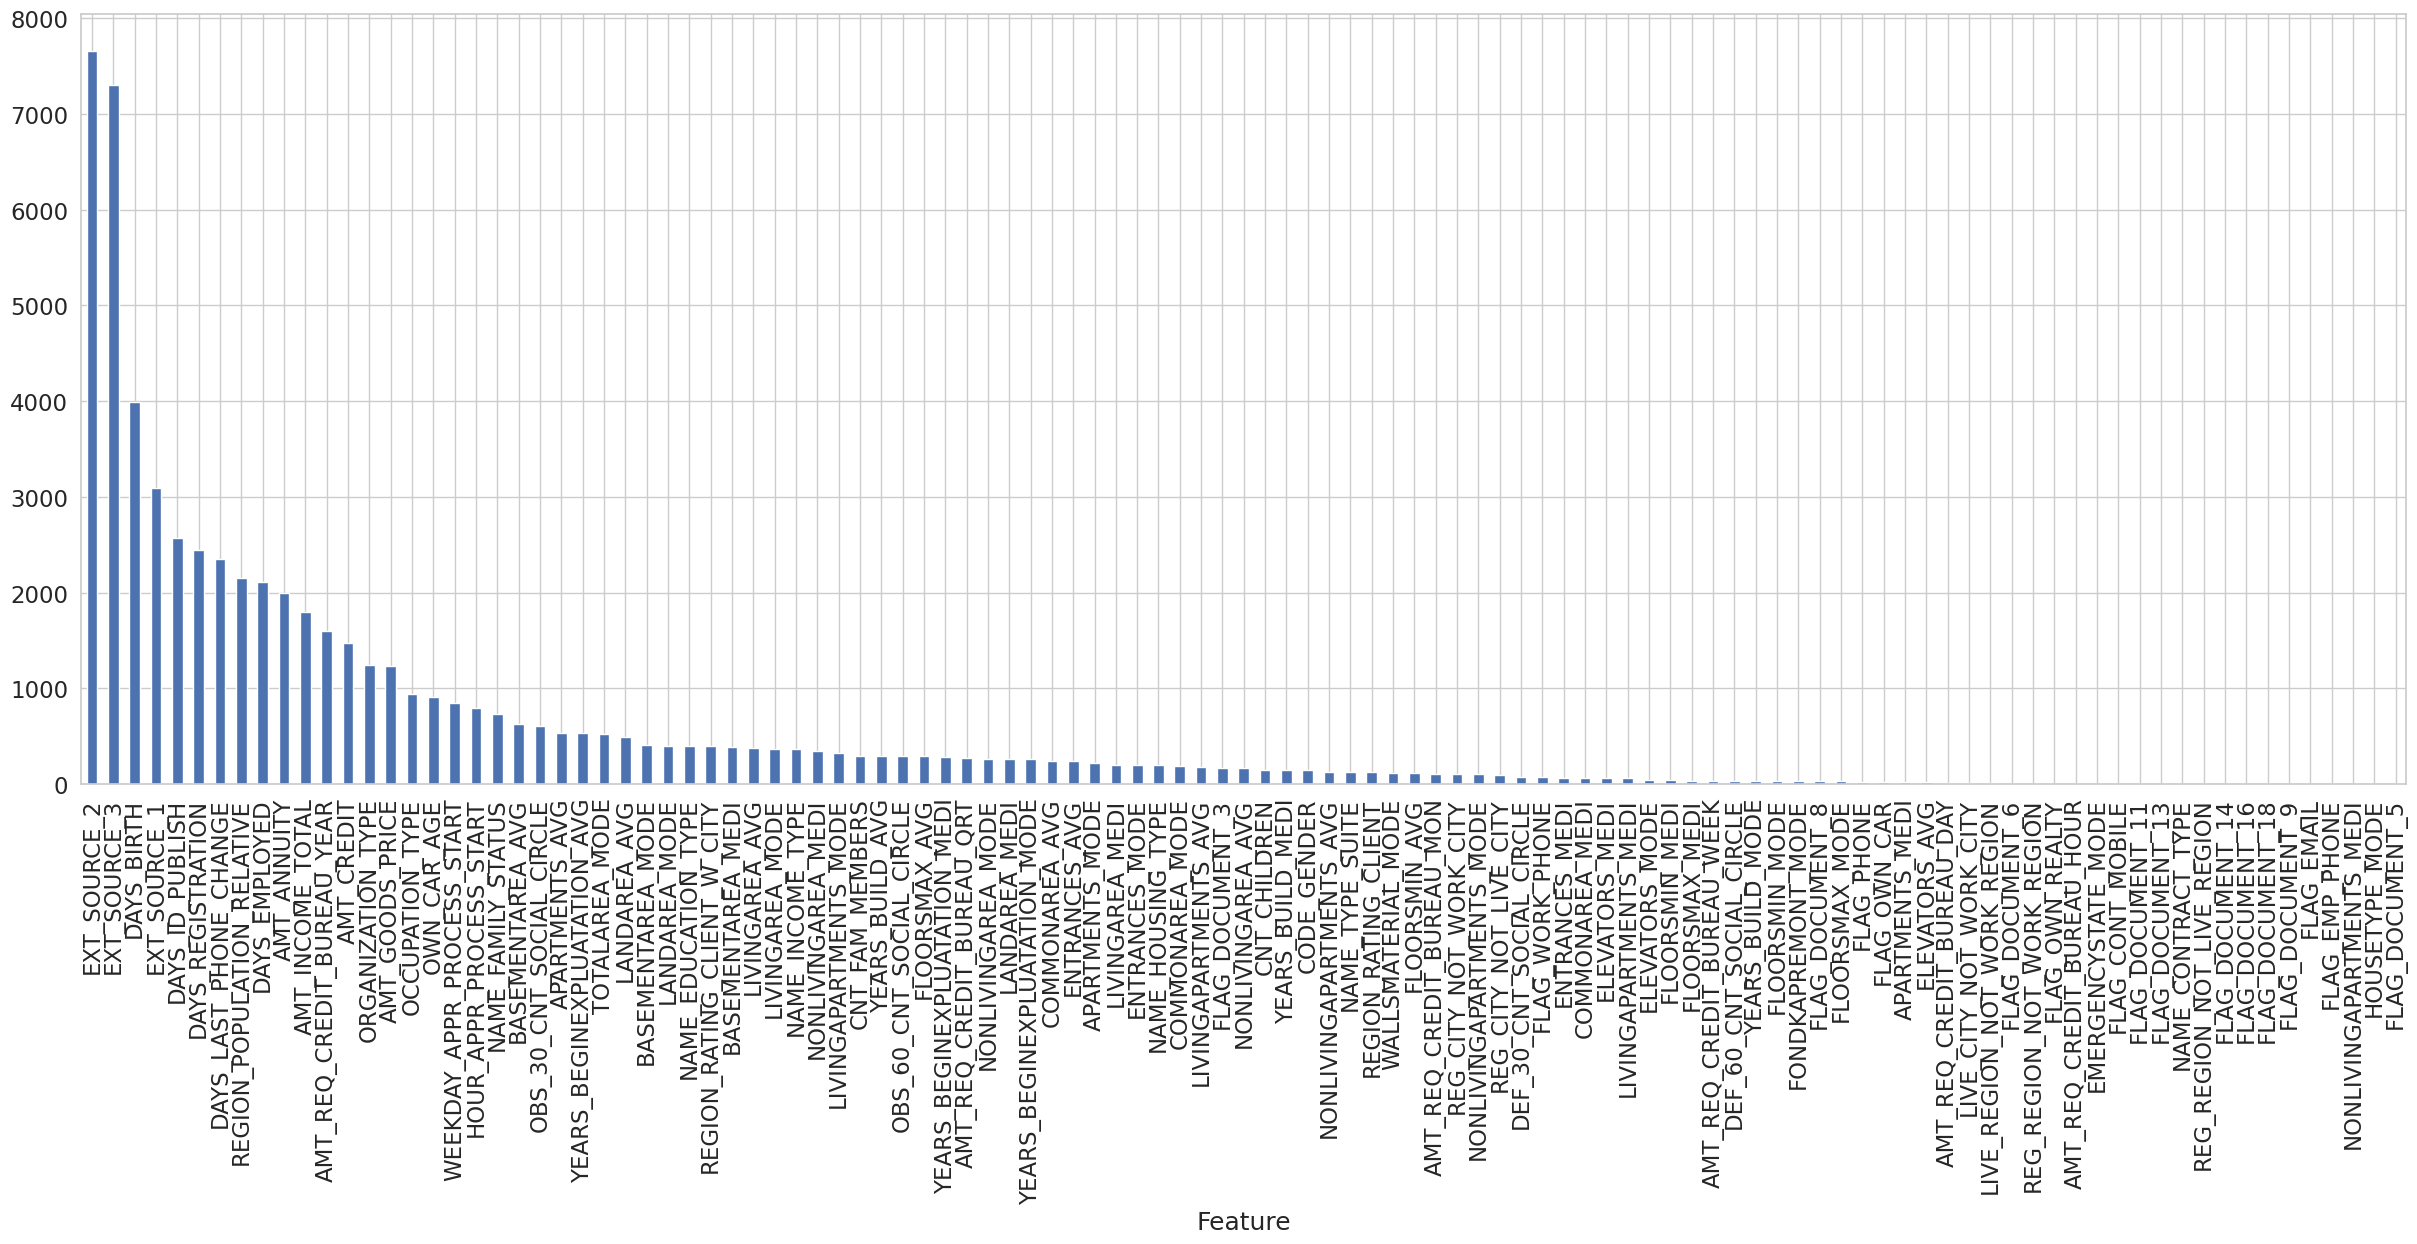

In [25]:
%%time

# Fast feature importances calculation
fast_fi = automl_rd.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [26]:
%%time

# Accurate feature importances calculation with detailed info (Permutation importances) -  can take long time to calculate
accurate_fi = automl_rd.model.get_feature_scores('accurate', test_data, silent = True)

CPU times: user 3min 11s, sys: 9.4 s, total: 3min 20s
Wall time: 1min 11s


<Axes: xlabel='Feature'>

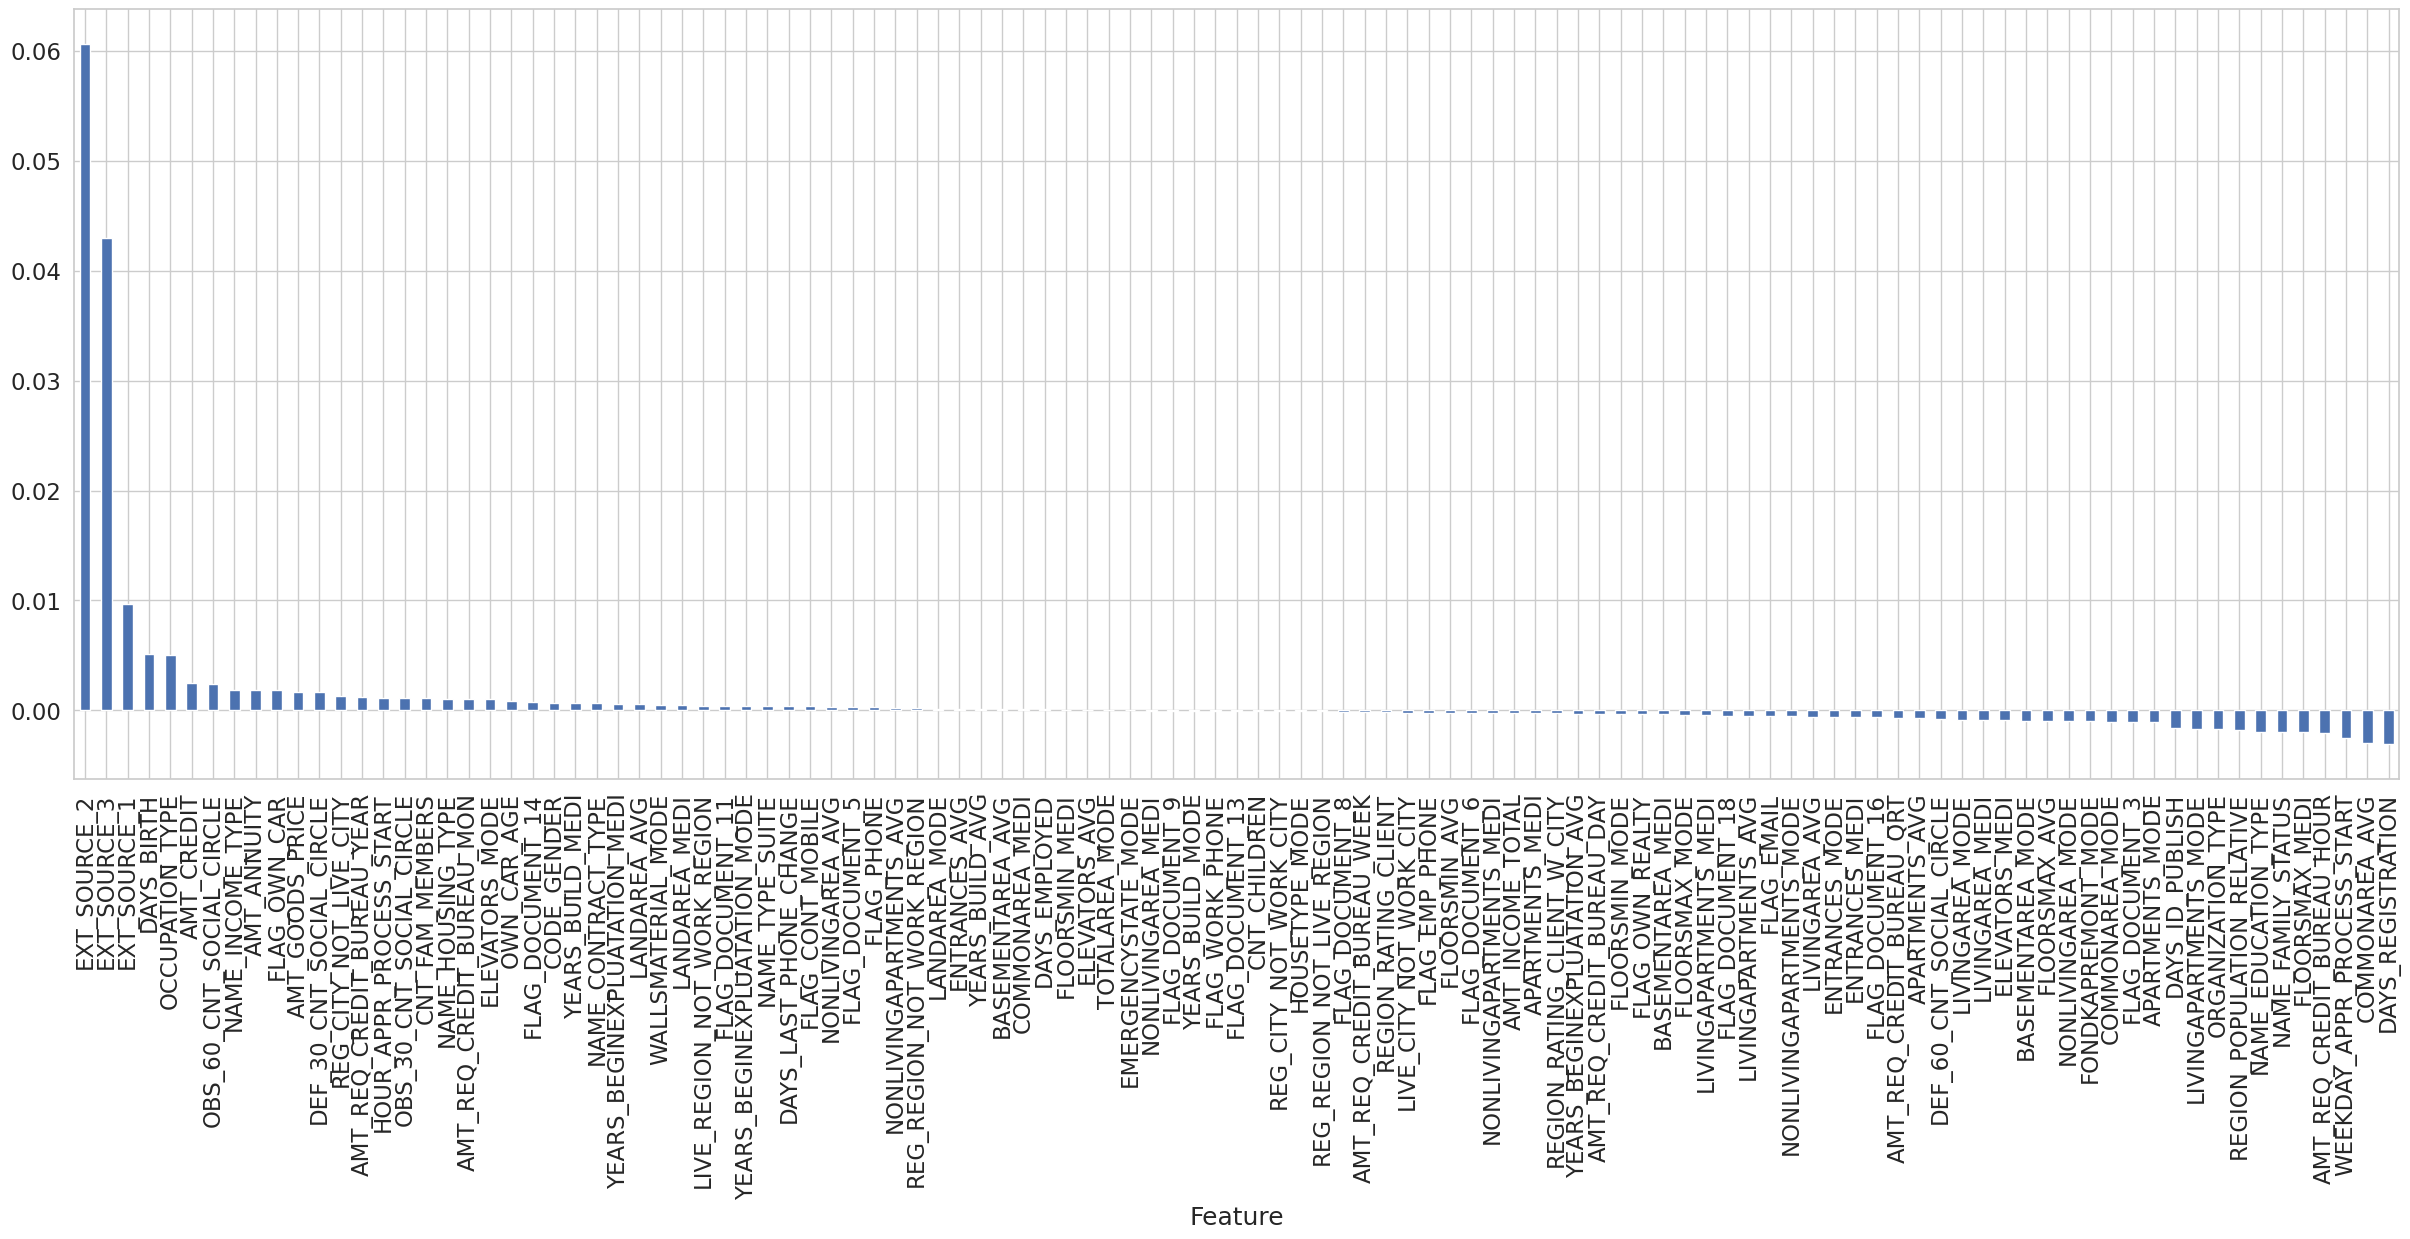

In [27]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

### 4.3 Shapley values

In [28]:
explainer = SSWARM(automl_rd.model)
shap_values = explainer.shap_values(test_data, n_jobs=N_THREADS)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:43<00:00, 13.41it/s]


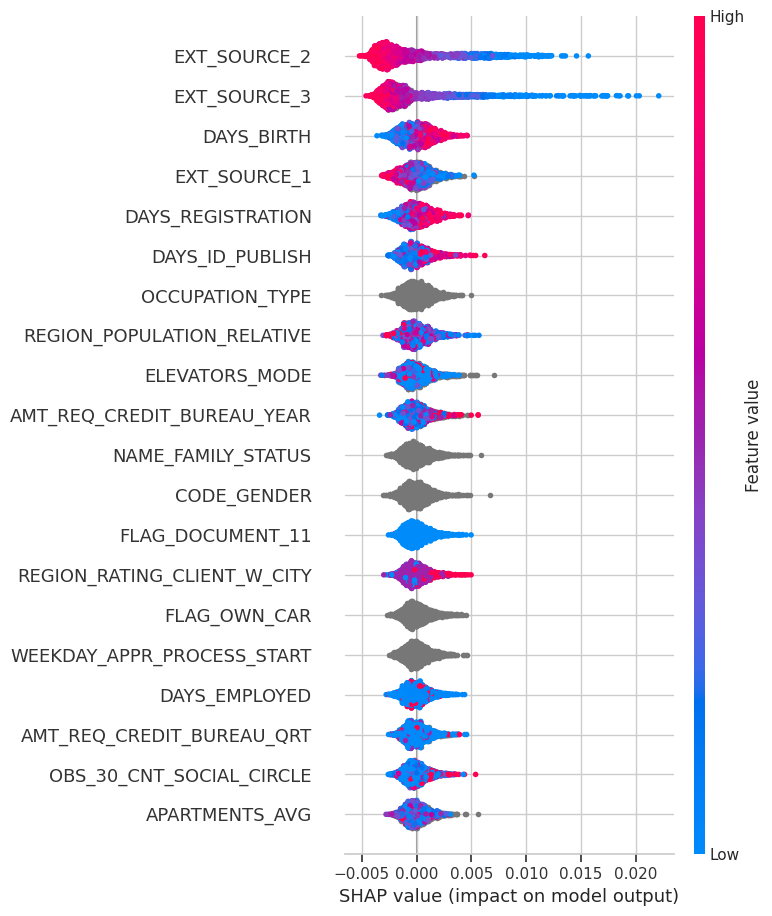

In [29]:
# summary plot
import shap
shap.summary_plot(shap_values[1], test_data[explainer.used_feats])

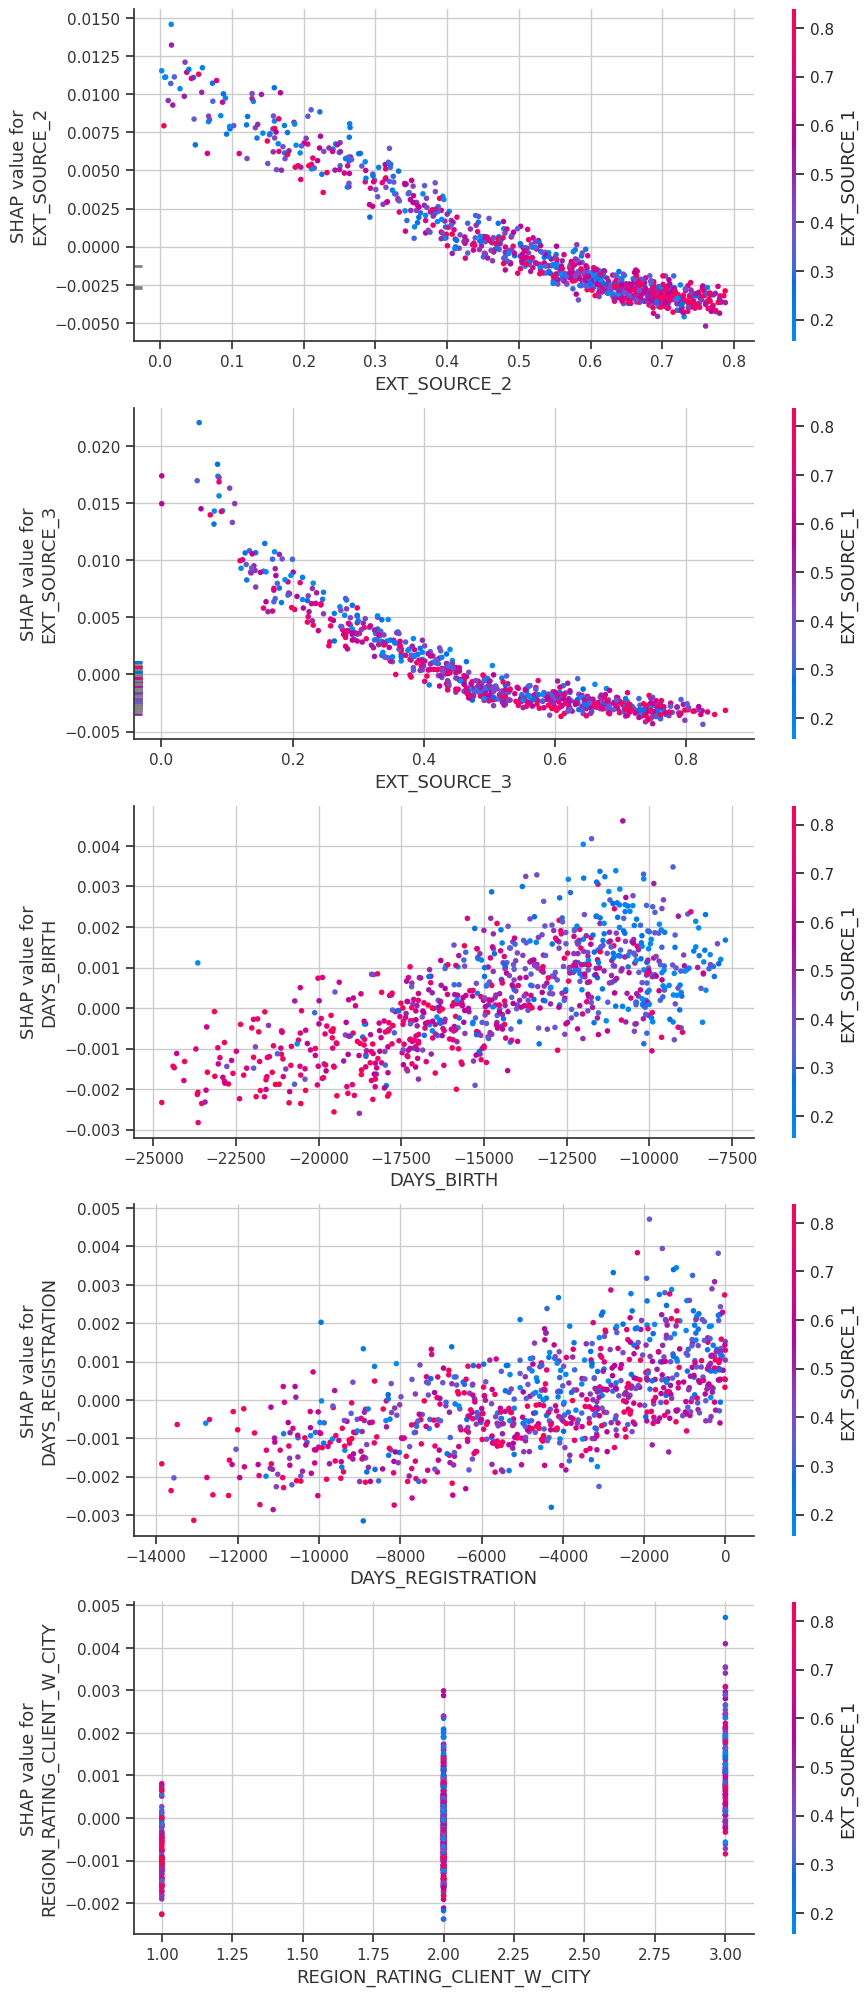

In [30]:
# dependence plots
import matplotlib.pyplot as plt

feats = ["EXT_SOURCE_2", "EXT_SOURCE_3", "DAYS_BIRTH", "DAYS_REGISTRATION", "REGION_RATING_CLIENT_W_CITY"]
fig, ax = plt.subplots(nrows=len(feats), ncols=1, figsize=(10, 5*len(feats)))

for i, feat in enumerate(feats):
    shap.dependence_plot(feat, shap_values[1], test_data[explainer.used_feats],
                         show=False, ax=ax[i], interaction_index="EXT_SOURCE_1")



In [31]:
# individual force plots
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], test_data[explainer.used_feats].iloc[0])

In [32]:
# overall force plot
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][:500], test_data[explainer.used_feats].iloc[:500])

# Bonus: where is the automatic report?


As we used `automl_rd` in our training and prediction cells, it is already ready in the folder we specified - you can check the output folder and find the `tabularAutoML_model_report` folder with `lama_interactive_report.html` report inside (or just [click this link](tabularAutoML_model_report/lama_interactive_report.html) for short). It's interactive so you can click the black triangles on the left of the texts to go deeper in selected part.

## 5. Spending more from TIMEOUT - `TabularUtilizedAutoML` usage

To spend (almost) all the `TIMEOUT` time for building the model we can use `TabularUtilizedAutoML` preset instead of `TabularAutoML`, which has the same API. By default ```TabularUtilizedAutoML``` model trains with 7 different parameter configurations (see [this](https://github.com/sb-ai-lab/LightAutoML/tree/master/lightautoml/automl/presets/tabular_configs) for more details) sequentially, and if there is time left, then whole AutoML pipeline with these configs is run again with another cross-validation seed, and so on. Then results for each pipeline model are averaged over the considered validation seeds, and all averaged results at the end are also combined through blending. User can set his own set of configs by passing list of paths to according files in ```configs_list``` argument during ```TabularUtilizedAutoML``` instance initialization. Such configs allow the user to configure all pipeline parameters and can be used for any available preset. 

In [ ]:
utilized_automl = TabularUtilizedAutoML(
    task = task, 
    timeout = 900,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [ ]:
%%time 

out_of_fold_predictions = utilized_automl.fit_predict(train_data, roles = roles, verbose = 1)

In [ ]:
print('out_of_fold_predictions:\n{}\nShape = {}'.format(out_of_fold_predictions, out_of_fold_predictions.shape))

In [ ]:
print(utilized_automl.create_model_str_desc())

Feature importances calculation for `TabularUtilizedAutoML`:

In [ ]:
%%time

# Fast feature importances calculation
fast_fi = utilized_automl.get_feature_scores('fast', silent=False)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

Note that in ```TabularUtilizedAutoML``` the first config doesn't have a LGBM feature selector (but second one already has it), so if there is enough time only for training with the first config, then ```'fast'``` feature importance calculation method won't work. ```'accurate'``` method will still work correctly.

In [ ]:
%%time

# Accurate feature importances calculation
fast_fi = utilized_automl.get_feature_scores('accurate', test_data, silent=True)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

Prediction on holdout and metric calculation:

In [ ]:
%%time

test_predictions = utilized_automl.predict(test_data)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

In [ ]:
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, out_of_fold_predictions.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

It is also important to note that using a ```ReportDeco``` decorator for a ```TabularUtilizedAutoML``` is not yet available.

## Bonus: another tasks examples

### Regression task

Without big differences from the case of binary classification, LightAutoML can solve the regression problems.

Here you will use Ames Housing dataset. Load the data, split it into train and validation parts:

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/reneemarama/aiming_high_in_aimes/master/datasets/train.csv')
data.head()

In [ ]:
data.shape

In [ ]:
train_data, test_data = train_test_split(
    data, 
    test_size=TEST_SIZE,  
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Now we have a regression task, and it is necessary to specify it in ```Task``` object. Note that default loss and metric for regression task is MSE, but you can use any available functions, for example, MAE:

In [ ]:
task = Task('reg', loss='mae', metric='mae')

Specifying columns roles:

In [ ]:
roles = {
    'target': 'SalePrice',
    'drop': ['Id', 'PID']
}

Building AutoML model:

In [ ]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

Training:

In [ ]:
%%time 
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)

In [ ]:
%%time

test_predictions = automl.predict(test_data)

In [ ]:
print(f'Prediction for te_data:\n{test_predictions[:10]}\nShape = {test_predictions.shape}')

In [ ]:
from sklearn.metrics import mean_absolute_error
print(f'OOF score: {mean_absolute_error(train_data[roles["target"]].values, out_of_fold_predictions.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(test_data[roles["target"]].values, test_predictions.data[:, 0])}')

In the same way as in the previous example with binary classification, you can build a detailed report using ```ReportDeco```, calculate feature importances, use ```TabularUtilizedAutoML``` etc.

### Multi-class classification

Now let's consider multi-class classification. 
Here you will use [Anuran Calls (MFCCs) Data Set](https://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29):

In [ ]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

data = pd.read_csv(
    ZipFile(
        BytesIO(
            urlopen(
                "https://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran%20Calls%20(MFCCs).zip"
            ).read()
        )
    ).open('Frogs_MFCCs.csv')
)

data.head()

In [ ]:
train_data, test_data = train_test_split(
    data, 
    test_size=TEST_SIZE,        
    shuffle=True, 
    random_state=RANDOM_STATE   
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Now we indicate that we have multi-class classification problem. Default metric and loss is cross-entropy function. 

In [ ]:
task = Task('multiclass')

Set the column roles, build and train AutoML model:

In [ ]:
roles = {
    'target': 'Species',
    'drop': ['RecordID'] 
    
}

In [ ]:
automl = TabularAutoML(
    task = task, 
    timeout = 900,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

Note that **in case of multi-class classification default pipeline architecture has a slightly different look**. First level is the same as level in default binary classification and regression, second level consists of linear regression and LightGBM model and the third is blending. It was decided to use two levels in default architecture based on the results of experiments on different tasks and data, where it gave an increase in model quality. Intuitively, this can be explained by the fact that only at the second and subsequent levels, the model that predicts the probability of belonging to one of the classes can see what the models that predict the rest of the classes see, that is, the models are able to exchange information about classes. Final prediction is blended from last pipeline level. 

In [ ]:
%%time 
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)

In [ ]:
%%time

test_predictions = automl.predict(test_data)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

It is also important to note that the ```Reader``` object may re-label classes during training. To see the new labelling, you can call ```.class_mapping``` method of ```Reader``` object. If the output dict is empty, then the original order and class layout has been preserved.

In [ ]:
automl.reader.class_mapping

Just in case, in order to avoid problems, it is better to relabel known class labels when calculating metrics, for example, in this or similar way:

In [ ]:
mapping = automl.reader.class_mapping
def map_class(x):
    return mapping[x]

mapped = np.vectorize(map_class)
mapped(train_data['Species'].values)

In [ ]:
from sklearn.metrics import log_loss
print(f'OOF score: {log_loss(mapped(train_data[roles["target"]].values), out_of_fold_predictions.data)}')
print(f'HOLDOUT score: {log_loss(mapped(test_data[roles["target"]].values), test_predictions.data)}')

Feature importance calculation, building reports, time management etc are also available for multiclass classification.

### Multi-label classifcation

Now let's consider multi-label classification task, here you will use the same dataset as in section above (Anuran Calls (MFCCs) Data Set ). Let's pick labels in each column:

In [ ]:
data['AdenomeraHylaedactylus'] = (data['Species'] == 'AdenomeraHylaedactylus').astype(int)
data['Adenomera'] = (data['Genus'] == 'Adenomera').astype(int)
data['Leptodactylidae'] = (data['Family'] == 'Leptodactylidae').astype(int)

In [ ]:
data.head()

In [ ]:
targets = ['Leptodactylidae', 'Adenomera', 'AdenomeraHylaedactylus']

Split it to train and validation:

In [ ]:
train_data, test_data = train_test_split(
    data, 
    test_size=TEST_SIZE,  
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Indicate that we are solving multi-label classification problem. Default metric and loss for this task is logloss.

In [ ]:
task = Task('multilabel')

Specifying the roles. Now we have several columns with target variables, and it's necessary to specify them all.

In [ ]:
roles = {
    'target': ['Leptodactylidae', 'Adenomera', 'AdenomeraHylaedactylus'],
    'drop': ['RecordID', 'Species', 'Genus', 'Family']
}

Create ```TabularAutoML``` instance. One of the differences in this case is that by default, random forest algorithm will be used at the end before blending. 

In [ ]:
automl = TabularAutoML(
    task = task, 
    timeout = 3600,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}, #TODO: N_THREADS
    general_params = {'use_algos': 'auto'}
)

Training:

In [ ]:
%%time 
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)

Get a prediction on the test data:

In [ ]:
%%time

test_predictions = automl.predict(test_data)
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')

Note that in case of multi-label classification classes order always remains unchanged.



In [ ]:
automl.reader.class_mapping

It is importatnt to note that in this case models taken in the final composition did not have time to learn on all cross-validation folds, so their predicts in them will be NaNs:

In [ ]:
np.unique(np.isnan(out_of_fold_predictions.data))

But for new data, normal numerical predictions are made:

In [ ]:
np.unique(np.isnan(test_predictions.data))

Therefore, we can calculate the logloss from sklearn only on the test set (because of NaNs):

In [ ]:
from sklearn.metrics import log_loss
print(f'HOLDOUT score: {log_loss(test_data[targets].values, test_predictions.data)}')

### Multi-output regression

For completeness, let's consider multi-output regression task. Here you will use [Energy Efficiency dataset](https://www.kaggle.com/datasets/ujjwalchowdhury/energy-efficiency-data-set).

Data loading and splitting:

In [ ]:
# !pip install openpyxl

In [ ]:
columns = [
    'relative_compactness', 'surface_area', 'wall_area', 'roof_area',
    'overall_height', 'orientation', 'glazing_area',
    'glazing_area_distribution', 'heating_load', 'cooling_load'
]
data = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx", names=columns, header=None)
data = data.drop(index=0, inplace=False)
data

In [ ]:
train_data, test_data = train_test_split(
    data, 
    test_size=TEST_SIZE,  
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

In [ ]:
train_data = train_data.astype('float')
test_data = test_data.astype('float')

Specifying the ```Task``` object. Default loss and metric for multi-output regression is MAE.

In [ ]:
task = Task('multi:reg')

Roles setting:

In [ ]:
roles = {
    'target': ['heating_load', 'cooling_load'],
}

Create ```TabularAutoML``` instance:

In [ ]:
automl = TabularAutoML(
    task = task, 
    timeout = 600,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    general_params = {'use_algos': 'auto'}
)

By default, random forest algorithm will be used at the end before blending. 

Training and getting out-of-fold prediction:

In [ ]:
%%time 
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)

Make prediction on test data:

In [ ]:
%%time

test_predictions = automl.predict(test_data)

Evaluate regression quality:

In [ ]:
from sklearn.metrics import mean_absolute_error
mae_h_train = mean_absolute_error(train_data["heating_load"].values, out_of_fold_predictions.data[:, 0])
mae_c_train = mean_absolute_error(train_data["cooling_load"].values, out_of_fold_predictions.data[:, 1])
mae_h_test = mean_absolute_error(test_data["heating_load"].values, test_predictions.data[:, 0])
mae_c_test = mean_absolute_error(test_data["cooling_load"].values, test_predictions.data[:, 1])
print(f'OOF score, heating_load: {mae_h_train}')
print(f'OOF score, cooling_load: {mae_c_train}')
print(f'HOLDOUT score, heating_load: {mae_h_test}')
print(f'HOLDOUT score, cooling_load: {mae_c_test}')
print(f'OOF score, general: {(mae_h_train + mae_c_train) / 2}')
print(f'HOLDOUT score, general: {(mae_h_test + mae_c_test) / 2}')

## Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/AILab-MLTools/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)